In [1]:
import glob
import os
import time
import urllib.parse
from datetime import datetime, date

import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pytz
import tensorflow as tf
from astral import LocationInfo
from astral.sun import sun
from keras import layers, models
from prophet import Prophet
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier

import strat_defs # custom functions
import prep_data

In [2]:
# Uncomment if running prophet (prophet prints something each time)
# Doesn't work with restart run all ¯\_(ツ)_/¯
import logging
logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)

In [3]:
def gen_powerset(some_list):
    powerset = [[]]

    for i in some_list:
        powerset += [x + [i] for x in powerset]

    return powerset

### Configuration

In [5]:
moving_average_config = prep_data.MovingAverageConfig(short_window=10, long_window=50)
bollinger_config = prep_data.BollingerConfig(window=90, num_std=3.0)

indicator_config = prep_data.IndicatorConfig(
    ticker='SPY',
    target='Adj Close', # probably should always be Adj Close
    rsi_window = 30,
    moving_average=moving_average_config,
    bollinger=bollinger_config
)

logit_config = strat_defs.LogitConfig(max_iter=1000, proba=0.45, c=0.01, pca_n_components=0.90)
mlp_config = strat_defs.MLPConfig(max_iter=2000, proba=0.5, alpha=0.0001, hidden_layer_sizes = (32, 16))
keras_config = strat_defs.KerasConfig(proba=0.5, sequence_length=30, epochs=20)

backtest_config = strat_defs.BacktestConfig(
    overbought = 70,
    knn_proba = 0.5,
    xgboost_proba = 0.4,
    svc_proba = 0.5,
    logit = logit_config,
    mlp = mlp_config,
    keras = keras_config
)

### Build dataframe for testing

In [7]:
prepd_data = prep_data.prep_data(config=indicator_config, drop_tickers=True)

### Set backtest_strategy Parameters

**s_date**\
data start date S&P 500 minimum is 1993-01-29, Wikipedia page views minimum is 2015-07-01

**exclude_vars**\
enum {"Open","High","Low","Close","Adj Close","Volume","movement", "views"}

**strategy_list**\
enum {"Hold","SMA","RSI","VWAP","Bollinger","Breakout","Prophet","Logit","RandomForest","XGBoost", "XGBoost_scaled","SVC","MLP","Keras","Perfection","LinearSVC"}

\
*If testing Breakout, "High" and "Low" cannot be excluded*

In [10]:
s_date = "2015-07-01"
exclude_vars = ()#("Open","High","Low","Close")

initial_capital = 10000
initial_train_period = 1890#7535
bko_window = 20
knn_proba = 0.5
xgboost_proba = 0.4
svc_proba = 0.53
keras_proba = 0.5
keras_sequence_length = 30
random_state = 42
n_jobs = None

# Stocks to test
to_test = ["SPY","AAPL","GOOG","F","IBM","KO","WMT"] # Invest in stock where max probability of increase
                                                     # If max probability of all tickers < 0.7, then sell and buy nothing

# Strategies to test
strategy_list = ["Hold","Logit","Logit_PCA","KNN","XGBoost"]

### Run models

In [12]:
%%time
df_for_chart = prepd_data.loc[prepd_data['Date']>=s_date].reset_index(drop=True)
df_for_chart = df_for_chart.loc[:,~df_for_chart.columns.str.startswith(exclude_vars)]
df_for_chart = df_for_chart.dropna(axis='columns') # drop columns with an na

print(f'Training on data set with {len(df_for_chart)} rows and {df_for_chart.shape[1]-1} features')

# Calculate portfolio value over time
strat_bds = {}
strat_mods = {}
for strat in strategy_list:
    start_time = time.time()
    print(f'{strat}', end=" ")
    backtested_data,model,score = strat_defs.backtest_strategy(data=df_for_chart,
                                                               initial_capital=initial_capital,
                                                               strategy=strat,
                                                               target=indicator_config.target,
                                                               ticker=indicator_config.ticker,
                                                               config=backtest_config,
                                                               initial_train_period=initial_train_period,
                                                               bko_window=bko_window,
                                                               knn_proba=knn_proba,
                                                               xgboost_proba=xgboost_proba,
                                                               svc_proba=svc_proba,
                                                               random_state=random_state,
                                                               n_jobs=n_jobs)
    end_time = time.time()
    print(f'score = {score}, time = {end_time-start_time}')
    
    strat_bds[strat] = backtested_data
    strat_mods[strat] = model

Training on data set with 2412 rows and 27 features
Hold score = None, time = 0.002549886703491211
Logit score = 0.5545416839485691, time = 3.409804105758667
Logit_PCA score = None, time = 3.280513048171997
KNN score = 0.6885109912899212, time = 1.513016939163208
CPU times: user 1min 7s, sys: 8.08 s, total: 1min 15s
Wall time: 8.29 s


In [13]:
strats_not_hold = [x for x in strategy_list if x not in ["Hold","LinearSVC","SVC"]]

combos = [x for x in gen_powerset(strats_not_hold) if len(x) > 1]

mod_mod_dic = {}
for mods in combos:
    # Model of models
    df_prev = strat_bds[mods[0]][['Date','Daily_Return','Target','proba_1','Signal']]
    df_prev = df_prev.rename(columns={'proba_1': 'proba_1'+mods[0], 'Signal': 'Signal_'+mods[0]})
    for i in mods[1:]:
        mod_mod = strat_bds[i][['Date','proba_1','Signal']].rename(columns={'proba_1': 'proba_1'+i, 'Signal': 'Signal_'+i})
        mod_mod = mod_mod.merge(df_prev,on='Date')
        df_prev = mod_mod
    
    # All strats predict 0
    signal_columns = mod_mod.columns[mod_mod.columns.str.contains('Signal')]
    
    mod_mod['Signal_all0'] = np.where(mod_mod[signal_columns].eq(0).all(axis=1), 0, 1) 
    
    mod_mod['Strategy_Return_all0'] = mod_mod['Signal_all0'].shift(1) * mod_mod['Daily_Return']
    mod_mod['Portfolio_Value_all0'] = (1 + mod_mod['Strategy_Return_all0']).cumprod() * initial_capital
    
    # Using strategy with most confident prediction (furthest from 50%)
    proba_cols = [col for col in mod_mod.columns if col.startswith('proba_1')]
    
    for i in proba_cols:
        mod_mod["dist_"+i] = abs(mod_mod[i] - 0.5)
    
    dist_cols = [col for col in mod_mod.columns if col.startswith('dist_')]
    
    mod_mod['proba_1max_col'] = mod_mod[dist_cols].idxmax(axis=1,skipna=True)
    mod_mod['proba_1max_col'] = mod_mod['proba_1max_col'].str.replace("dist_","")
    
    mod_mod['proba_1max'] = mod_mod.apply(
        lambda row: row[row['proba_1max_col']] if pd.notnull(row['proba_1max_col']) else 1, axis=1
    )
    
    mod_mod['Signal'] = mod_mod['proba_1max'].round()
    
    mod_mod['Strategy_Return'] = mod_mod['Signal'].shift(1) * mod_mod['Daily_Return']
    mod_mod['Portfolio_Value'] = (1 + mod_mod['Strategy_Return']).cumprod() * initial_capital

    mod_mod_dic["_".join(mods)] = mod_mod

/var/folders/5z/r78_k4tx73jc7k9lt835kddw0000gn/T/ipykernel_13503/874915451.py:31: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  mod_mod['proba_1max_col'] = mod_mod[dist_cols].idxmax(axis=1,skipna=True)
/var/folders/5z/r78_k4tx73jc7k9lt835kddw0000gn/T/ipykernel_13503/874915451.py:31: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  mod_mod['proba_1max_col'] = mod_mod[dist_cols].idxmax(axis=1,skipna=True)
/var/folders/5z/r78_k4tx73jc7k9lt835kddw0000gn/T/ipykernel_13503/874915451.py:31: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  mod_mod['proba_1max_col'] = mod_mod[dist_cols].idxmax(axis=1,skipna=True)
/var/folders/5z/r78_k4tx73jc7k9lt835kddw0000gn/T/ipy

### Results

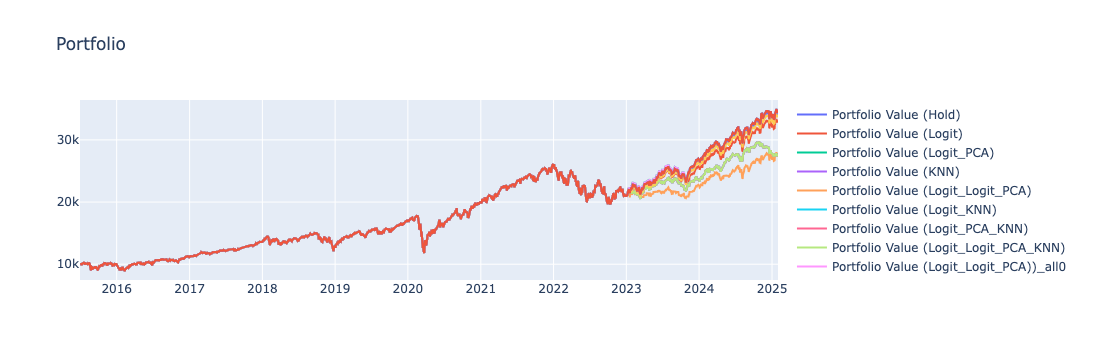

In [32]:
# Plot Daily Portfolio Value
fig = go.Figure()

for strat in strategy_list:
    fig.add_trace(go.Scatter(x=strat_bds[strat]['Date'], y=strat_bds[strat]['Portfolio_Value'],
                             mode='lines', name=f'Portfolio Value ({strat})'))

try:
    for mods in combos:
        df = mod_mod_dic["_".join(mods)]
        fig.add_trace(go.Scatter(x=df['Date'], y=df['Portfolio_Value'],
                                 mode='lines', name=f"Portfolio Value ({'_'.join(mods)})"))
    
    for mods in combos:
        df = mod_mod_dic["_".join(mods)]
        fig.add_trace(go.Scatter(x=df['Date'], y=df['Portfolio_Value_all0'],
                                 mode='lines', name=f"Portfolio Value ({'_'.join(mods)}))_all0"))
except:
    pass

fig.update_layout(title="Portfolio")
fig.show()

In [16]:
# XGBoost review
not_selected_features_cols = ['Date','Target','Signal','proba_0','proba_1' ,'Strategy_Return','Portfolio_Value']

selected_features = [x for x in list(strat_bds['XGBoost']) if x not in not_selected_features_cols]

df = pd.DataFrame({
    'feature_importances': strat_mods['XGBoost'].feature_importances_,
    'selected_features':selected_features
})
df = df.loc[df['feature_importances']!=0]
df = df.sort_values(by='feature_importances',ascending=False).reset_index(drop=True)

fig = go.Figure(go.Bar(x=df['feature_importances'], y=df['selected_features'], orientation='h'))

fig.update_layout(title="Feature Importance (XGBoost)", xaxis_title="Importance",
                  yaxis={'categoryorder':'total ascending'},
                  height=600)

fig.show()

print('Feature importances in XGBoost model')
df.loc[df['selected_features'].isin(["sunlight_nyc","federal_funds_rate",
                                     "high_temp_nyc","low_temp_nyc","precipitation_PRCP_nyc","precipitation_SNOW_nyc",
                                     "streak","streak0","streak1","next_is_0","next_is_1","prob_next_is_0","prob_next_is_1"])]

KeyError: 'XGBoost'

In [30]:
# % right
combos_join = ["_".join(x) for x in combos]

dat = []
for i in strategy_list:
    cc = strat_bds[i].dropna().reset_index(drop=True)
    cc['win'] = cc['Target']==cc['Signal']

    win = cc['win'].value_counts(normalize=True)[True]

    dat.append(f'{win:.2%}')

for i in combos_join:
    cc = mod_mod_dic[i].dropna().reset_index(drop=True)
    cc['win'] = cc['Target']==cc['Signal']

    win = cc['win'].value_counts(normalize=True)[True]

    dat.append(f'{win:.2%}')


review = pd.DataFrame({'strategy': strategy_list+combos_join, 'pct_right': dat})
review.sort_values(by='pct_right', ascending=False)

,strategy,pct_right
2,Logit_PCA,58.24%
1,Logit,57.09%
0,Hold,55.21%
4,Logit_Logit_PCA,52.87%
3,KNN,47.32%
5,Logit_KNN,47.32%
6,Logit_PCA_KNN,47.32%
7,Logit_Logit_PCA_KNN,47.32%


### Testing

In [ ]:
########################################################################################################
# Testing ##############################################################################################
########################################################################################################

In [54]:
cols_for_review = ['Date','Adj Close_SPY','Target','streak0','streak1','proba_1','Signal','Portfolio_Value']

# prophet = strat_bds['Prophet'][cols_for_review+['predicted_price_tomorrow']]
logit = strat_bds['Logit'][cols_for_review]
logit_pca = strat_bds['Logit_PCA'][cols_for_review]
knn = strat_bds['KNN'][cols_for_review]
# boost = strat_bds['XGBoost'][cols_for_review]
# boost_scaled = strat_bds['XGBoost_scaled'][cols_for_review]
# svc = strat_bds['SVC'][cols_for_review]
# mlp = strat_bds['MLP'][cols_for_review]
# keras = strat_bds['Keras'][cols_for_review+['next_day_prediction']]

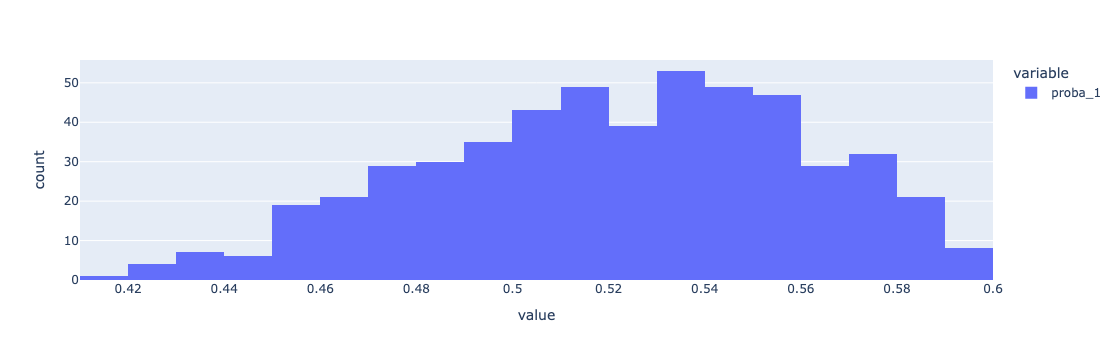

In [42]:
px.histogram(logit['proba_1'].dropna())

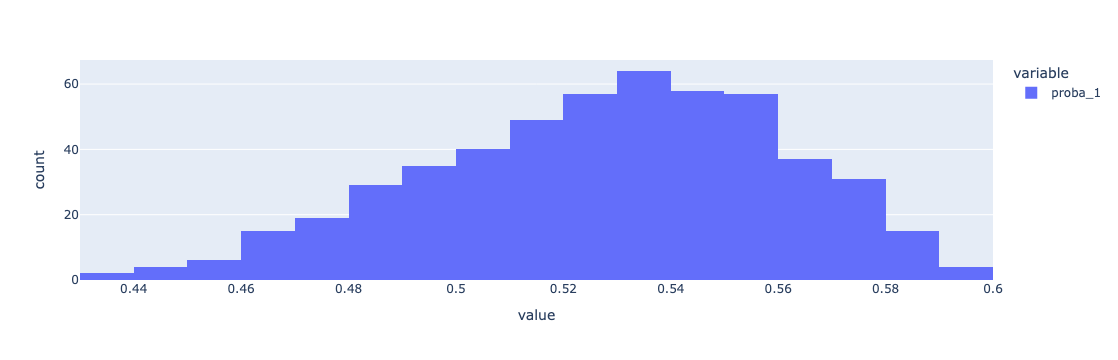

In [44]:
px.histogram(logit_pca['proba_1'].dropna())

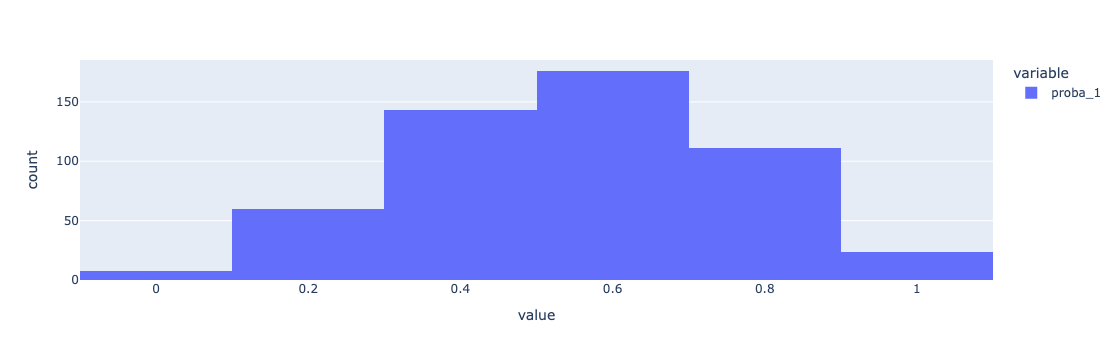

In [52]:
px.histogram(knn['proba_1'].dropna())

In [48]:
px.histogram(boost['proba_1'].dropna())

NameError: name 'boost' is not defined

In [50]:
px.histogram(svc['proba_1'].dropna())

NameError: name 'svc' is not defined